In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats import inter_rater as irr
import krippendorff as kd
import seaborn as sns

In [2]:
df = pd.read_csv("./annot_tables/results_melted.csv").drop(columns="Unnamed: 0")

In [3]:
# nformation Choices (IC), Sentence Construction449
# (SC), Word Choice (WC)
df.replace({
    "Choix de l'information": "Information\nChoice",
    "Construction des phrases": "Sentence\nConstruction",
    "Choix des mots": "Word\nChoice",
    "Illustrations": "Illustrations",
    "Qualité globales": "Overall Quality",
    "mbarthez-lora": "mBARThez+LoRA",
    "mistral-lora": "Mistral-7B+LoRA",
},
           inplace=True
)

In [4]:
likert_5_criteria = ["CA1", "CA2", "CA3", "CA4", "CA8"]

In [5]:
def agreement_rate(column):
    values, counts = np.unique(column, return_counts=True)
    return max(counts) / len(column)
    
def fleiss_kappa(x):
    values = x.filter(regex="coder*").values
    agg = irr.aggregate_raters(values)
    return irr.fleiss_kappa(agg[0], method='fleiss')

def krippendorff_alpha(values, level="ordinal"):
    return kd.alpha(values, level_of_measurement=level)

In [6]:
mapping = {
    'Très bon': 3,
    'Bon': 2,
    'Satisfaisant': 1,
    'Mauvais': -1,
    'Très mauvais': -2,
    'Oui': 1,
    'Non Applicable': 0,
    'Non': -1,
}

## ETR Guidelines

In [7]:
df_etr = df[df.criteria_type == "ETR"].replace({
    'Oui': 1,
    'Non Applicable': None,
    'Non': 0,
})

/tmp/ipykernel_2204592/3095368853.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_etr = df[df.criteria_type == "ETR"].replace({


In [8]:
df_etr.columns

Index(['example_id', 'model', 'source', 'target', 'prediction', 'dataset',
       'sample_id', 'annotator', 'criteria', 'value', 'criteria_theme',
       'criteria_type', 'criteria_score'],
      dtype='object')

In [9]:
def validation_rate(coder_results):
    value, criteria_score = coder_results["value"], coder_results["criteria_score"]
    return value.sum() / value.notna().sum()

In [10]:
df_quality = df[df.criteria_type == "global quality"].replace({
    'Très bon': 4,
    'Bon': 3,
    'Satisfaisant': 2,
    'Mauvais': 1,
    'Très mauvais': 0,
    'Oui': 1,
    'Non Applicable': 1,
    'Non': 0,
})

/tmp/ipykernel_2204592/3841071250.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_quality = df[df.criteria_type == "global quality"].replace({


/tmp/ipykernel_2204592/145238873.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return value.sum() / value.notna().sum()


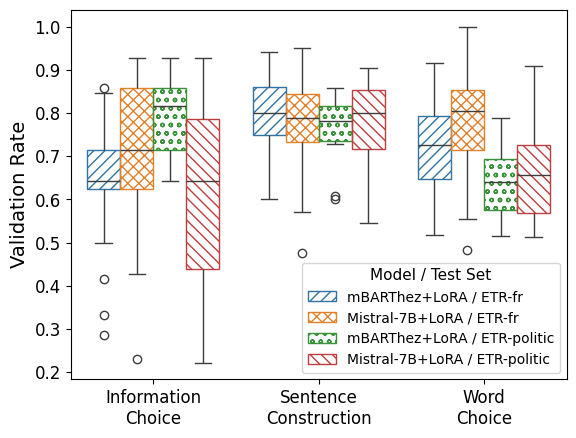

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

hatch_patterns = ["///", "xxx", "oo", "\\\\\\"]  # Customize as needed
x = df_etr.groupby(["sample_id", "model", "criteria_theme", "dataset"])[["value", "criteria_score"]].apply(validation_rate).to_frame().rename(columns={0: "validation_rate"})
x = x[~x.index.get_level_values(2).isin(["Illustrations"])]
x = x.reset_index()
x = x.replace({"FALC": "ETR-fr", "POLITIC": "ETR-politic"})
x['model_dataset'] = x['model'] + ' / ' + x['dataset']

# Define hatching patterns
unique_hues = x["model_dataset"].unique()
n_models = len(x["model"].unique())

# Create boxplot
ax = sns.boxplot(data=x, x="criteria_theme", y="validation_rate", hue="model_dataset")

# Apply hatching
for pi, hi in enumerate([(i // 3) % 4 for i in range(len(ax.patches[:-4]))]):
    patch = ax.patches[pi]
    h = hatch_patterns[hi]
    patch.set_hatch(h)
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

for pi, h in zip([-4, -3, -2, -1], hatch_patterns):
    patch = ax.patches[pi]
    patch.set_hatch(h)
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

# Set labels and legend with bold font
ax.set_ylabel("Validation Rate", fontsize=14)
ax.set_xlabel(None)
ax.legend(title="Model / Test Set", fontsize=10, title_fontsize=11)

# Increase tick font size and make them bold
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save figure
ax.get_figure().savefig("./figs/box_ETR_crit.pdf", bbox_inches='tight')


## Global Quality

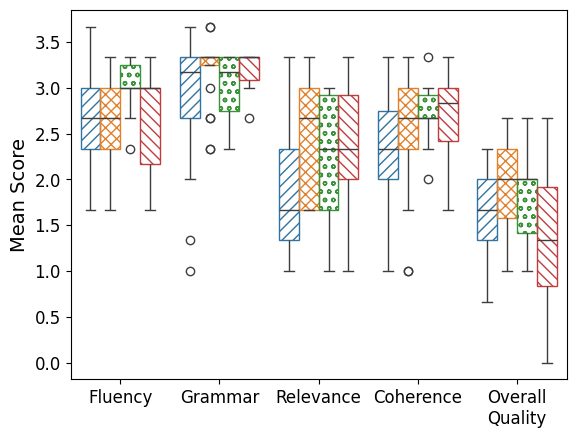

In [12]:
# df_quality = df[df.criteria_type == "global quality"].replace({
#     'Très bon': 1,
#     'Bon': 1,
#     'Satisfaisant': 1,
#     'Mauvais': ,
#     'Très mauvais': 0,
#     'Oui': 1,
#     'Non Applicable': 1,
#     'Non': 0,
# })

x = df_quality.groupby(["sample_id", "model", "criteria","dataset"])[["value", "criteria_score"]].apply(validation_rate).to_frame().rename(columns={0: "mean_score"})
x = x[~x.index.get_level_values(2).isin(["CA5", "CA6", "CA7"])]
x = x.reset_index()
x = x.replace({"FALC": "ETR-fr", "POLITIC": "ETR-pol"})
x = x.replace(
{
    "CA1": "Fluency",
    "CA2": "Grammar",
    "CA3": "Relevance",
    "CA4": "Coherence",
    "CA5": "Presence of Copying from the Original Text?",
    "CA6": "Presence of Random Repetitions?",
    "CA7": "Presence of Hallucination?",
    "CA8": "Overall\nQuality"
}

)
x['model_dataset'] = x['model'] + ' / ' + x['dataset']
ax = sns.boxplot(data=x, x="criteria", y="mean_score", hue="model_dataset", legend=False)
# ax.legend(title="Model")
# ax.tick_params(axis='x', rotation=30)
ax.set_ylabel("Mean Score", fontsize=14)
ax.set_xlabel(None)

# Increase tick font size and make them bold
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Define hatching patterns
unique_hues = x["model_dataset"].unique()
n_models = len(x["model"].unique())

# Apply hatching
for pi, hi in enumerate([(i // 5) % 4 for i in range(len(ax.patches[:]))]):
    patch = ax.patches[pi]
    h = hatch_patterns[hi]
    patch.set_hatch(h)
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')
# for pi, h in zip([-4, -3, -2, -1], hatch_patterns):
#     patch = ax.patches[pi]
#     patch.set_hatch(h)
#     fc = patch.get_facecolor()
#     patch.set_edgecolor(fc)
#     patch.set_facecolor('none')

ax.get_figure().savefig("./figs/box_global_crit.pdf", bbox_inches = 'tight')

In [13]:
df_iaa = df.pivot(
    index=['example_id', 'model', 'source', 'target', 'prediction', 
   'dataset', 'sample_id', 'criteria', 'criteria_theme', 'criteria_type'],
    columns='annotator',
    values='value'
).reset_index()

In [14]:
domains = (( 
    ['CI3', 'CI4', 'CI5', 'CI6', 'CI8', 'CPM1', 'CPM2', 
     'CPM3', 'CPM4', 'CPM5', 'CPM6', 'CPM7', 'CPM8', 'CPM9', 'CPM10', 
     'CPM11', 'CPM12', 'CPM13', 'CPM14', 'CPM15', 'CPM16', 'CPM17', 'CPM18', 
     'CPM19', 'CPM20', 'CPM21', 'I1', 'I2', 'CA5', 'CA6', 'CA7'],
     ["Oui", "Non", "Non Applicable"]
), (
    ['CA1', 'CA2', 'CA3', 'CA4', 'CA8'],
    ['Très bon', 'Bon', 'Satisfaisant', 'Mauvais', 'Très mauvais']
))
crit_to_domain = {
    c:domain for crits, domain in domains for c in crits
}

df_iaa["domain"] = df_iaa["criteria"].apply(lambda x: crit_to_domain[x])

In [15]:
def kdalpha(x):
    # crit = str(x["criteria"].iloc[0])
    # domain = crit_to_domain[crit]
    domain = np.array(x["domain"].iloc[0])
    values = x[x.filter(regex="coder").columns].T.values.astype(str)
    try:
        return kd.alpha(values, value_domain=domain, level_of_measurement="ordinal")
    except:
        return np.nan
    
df_iaa.groupby(["criteria"]).apply(kdalpha).mean()

/home/ledoyen202/.cache/pypoetry/virtualenvs/ecir2025-0R3xmSh3-py3.10/lib/python3.10/site-packages/krippendorff/krippendorff.py:364: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (o * d).sum() / (e * d).sum()
/tmp/ipykernel_2204592/2456095298.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_iaa.groupby(["criteria"]).apply(kdalpha).mean()


0.0891934469181762

In [16]:
mapping = {
    'Très bon': "Bon",
    'Bon': "Bon",
    'Satisfaisant': "Bon",
    'Mauvais': "Mauvais",
    'Très mauvais': "Mauvais",
    'Oui': "Oui",
    'Non Applicable': "Oui",
    'Non': "Non",
}

domains = (( 
    ['CI3', 'CI4', 'CI5', 'CI6', 'CI8', 'CPM1', 'CPM2', 
     'CPM3', 'CPM4', 'CPM5', 'CPM6', 'CPM7', 'CPM8', 'CPM9', 'CPM10', 
     'CPM11', 'CPM12', 'CPM13', 'CPM14', 'CPM15', 'CPM16', 'CPM17', 'CPM18', 
     'CPM19', 'CPM20', 'CPM21', 'I1', 'I2', 'CA5', 'CA6', 'CA7'],
     ["Oui", "Non"]
), (
    ['CA1', 'CA2', 'CA3', 'CA4', 'CA8'],
    ["Bon", "Mauvais"]
))



def kdalpha(x):
    domain = np.array(x["domain"].iloc[0])
    values = x[x.filter(regex="coder").columns].T.values.astype(str)
    try:
        return kd.alpha(values, value_domain=domain, level_of_measurement="ordinal")
    except:
        return np.nan

crit_to_domain = {
    c:domain for crits, domain in domains for c in crits
}

df_iaa["domain"] = df_iaa["criteria"].apply(lambda x: crit_to_domain[x])    

df_iaa.replace(mapping).groupby(["criteria"]).apply(kdalpha).mean()

/home/ledoyen202/.cache/pypoetry/virtualenvs/ecir2025-0R3xmSh3-py3.10/lib/python3.10/site-packages/krippendorff/krippendorff.py:364: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (o * d).sum() / (e * d).sum()
/tmp/ipykernel_2204592/4218905246.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_iaa.replace(mapping).groupby(["criteria"]).apply(kdalpha).mean()


0.12604324628833255